# Tradução utilizando Redes Neurais Recorrentes

Nesse documento, nós vamos construir um modelo de aprendizado de máquina para traduzir frases em alemão para inglês. Para isso, vamos utilizar a mesma arquitetura do Google: um modelo de rede neural sequência-para-sequência (neural sequence-to-sequence).

Para os detalhes das configurações do Google, recomendamos [Wu et al.](https://arxiv.org/abs/1609.08144). Enquanto que para o nosso modelo, nos basearemos em [Bahdanau et al.](https://arxiv.org/abs/1409.0473), um documento que serve como base para o modelo do Google.

## Visão geral
Nosso objetivo é converter uma frase de origem alemã em uma frase em inglês. Para fazer isso, primeiro codificaremos cada palavra da frase em alemão e, em seguida, decodificaremos uma frase em inglês, uma palavra de cada vez. Durante a decodificação, usaremos a atenção para observar as palavras codificadas em inglês à medida que avançamos.

Para treinar nosso modelo de tradução, precisamos de muitos pares de frases alemão-inglês traduzidas por tradutores profissionais. Usaremos a coleção Multi30k. Para treinar modelos maiores, os pesquisadores costumam usar os procedimentos do Parlamento Europeu.

## Instalações

### Bibliotecas

In [1]:
%pip install spacy --user
%pip install torchtext --user
%pip install -U torch==1.8.0 torchtext==0.9.0
%pip install wget

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


### Base de dados

In [2]:
!python -m spacy download en_core_web_lg
!python -m spacy download de_core_news_lg

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


You should consider upgrading via the 'C:\Users\User\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Bibliotecas

In [3]:
import spacy

import torch
import torch.nn as nn
from torchtext.legacy import data, datasets

import numpy as np

import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')

import time 

from IPython.display import Image

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Hiperparâmetros

In [4]:
use_gpu = torch.cuda.is_available()

# Pre-process
BATCH_SIZE = 16
MAX_SENT_LEN = 20
MIN_FREQ = 5

# Encoder e Decoder
DROPOUT_P = 0.0

# Beam search
BEAM_SIZE = 4
INIT_LPROB = -1e10

# Train
write_path = "bleu-best-model"
EARLY_STOP = 5
NUM_EPOCHS = 10

# Optimizer
LEARNING_RATE = 2e-3

## Pré-processamento
Nós pré-processamos os dados com a biblioteca spacy. No pré-processamento, dividimos nossa frase em tokens (palavras) e adicionamos tokens especiais $<s>$ e $</s>$ para marcar o início e o fim das frases. Também substituímos palavras que ocorrem menos de 5 vezes por um token  $<unk>$ (unknown), pois isso nos ajuda a manter nosso vocabulário em 3.124 palavras em inglês e 3.327 palavras em alemão.

In [5]:
def preprocess():
    '''
    Loads data from text files into iterators
    '''

    # Load text tokenizers
    spacy_de = spacy.load('de_core_news_lg')
    spacy_en = spacy.load('en_core_web_lg')

    def tokenize(text, lang = 'en'):
        if lang == 'de':
            return [tok.text for tok in spacy_de.tokenizer(text)]
        elif lang == 'en':
            return [tok.text for tok in spacy_en.tokenizer(text)]
        else:
            raise Exception('Invalid language')

    # Add beginning-of-sentence and end-of-sentence tokens 
    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    DE = data.Field(tokenize = lambda x: tokenize(x, 'de'))
    EN = data.Field(tokenize = tokenize, init_token = BOS_WORD, eos_token = EOS_WORD)

    # Create sentence pair dataset with max length equals to MAX_SENT_LEN
    train, val, test = datasets.Multi30k.splits(
        exts=('.de', '.en'), 
        fields = (DE, EN), 
        filter_pred = lambda x: max(len(vars(x)['src']), len(vars(x)['trg'])) <= MAX_SENT_LEN)

    # Build vocabulary and convert text to indices
    # Convert words that appear fewer than MIN_FREQ times to <unk>
    DE.build_vocab(train.src, min_freq = MIN_FREQ)
    EN.build_vocab(train.trg, min_freq = MIN_FREQ)

    # Create iterators to process text in batches of approx. the same length
    train_iter = data.BucketIterator(
        train, 
        batch_size = BATCH_SIZE,
        repeat = False, 
        sort_key = lambda x: len(x.src)
    )
    
    val_iter = data.BucketIterator(
        val, 
        batch_size = 1,
        repeat = False, 
        sort_key = lambda x: len(x.src)
    )
    
    return DE, EN, train_iter, val_iter

In [6]:
# Test
timer = time.time()
SRC, TGT, train_iter, val_iter = preprocess()

In [7]:
print('''This is a test of our preprocessing function. It took {:.1f} seconds to load the data. 
Our German vocab has size {} and our English vocab has size {}.
Our training data has {} batches, each with {} sentences, and our validation data has {} batches.'''.format(
time.time() - timer, len(SRC.vocab), len(TGT.vocab), len(train_iter), train_iter.batch_size, len(val_iter)))

This is a test of our preprocessing function. It took 9.4 seconds to load the data. 
Our German vocab has size 3327 and our English vocab has size 3124.
Our training data has 1690 batches, each with 16 sentences, and our validation data has 948 batches.


## O Modelo
Baseado na plataforma [OpenNMT](https://github.com/OpenNMT/OpenNMT-py).

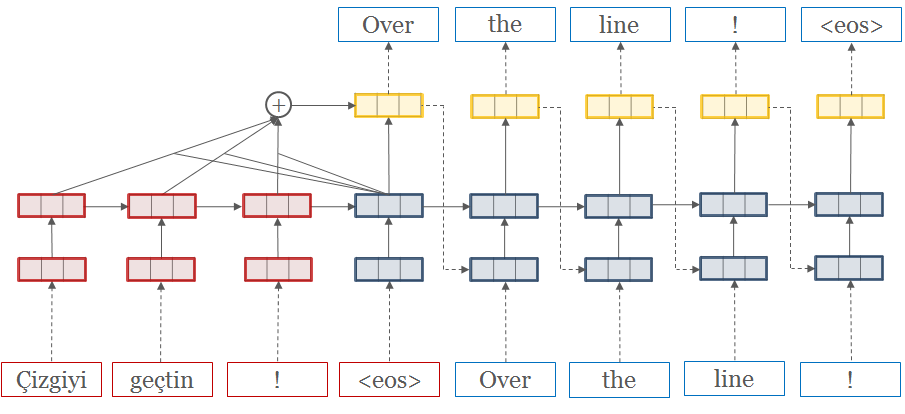

In [8]:
Image(filename = "Imagens/translation_diagram.png")

### Word Embeddings
O primeiro passo para ambos o codificador e decodificador é converter as palavras de entrada em vetores, uma forma com que o nosso modelo possa trabalhar em cima. Fazemos isso utilizando word embeddings, que são mapeamentos de cada palavra no nosso vocabulário para algum espaço de alta dimensão (no nosso caso, 300 dimensões).

In [9]:
def load_embeddings(path, TEXT, embedding_dim = 300):
    ''' 
    Creates a embedding from a file containing words and vector indices separated by spaces. 
    Modified from https://github.com/A-Jacobson/CNN_Sentence_Classification/blob/master/WordVectors.ipynb 
    '''
    
    with open(path, encoding = "utf8") as f:
        embeddings = np.zeros((len(TEXT.vocab), embedding_dim))
        
        for i, line in enumerate(f.readlines()):
            values = line.split()
            word = values[0]
            
            if word in TEXT.vocab.stoi:
                index = TEXT.vocab.stoi[word]
                
                try:
                    vector = np.array(values[1:], dtype = 'float32')
                except:
                    vector = np.array([0] * embedding_dim, dtype = 'float32')
                    print('error: ', word)
                
                embeddings[index] = vector
            
            if i % 10000 == 0:
                print('{i} complete'.format(i=i))
        
        return embeddings

In [10]:
# Save German embeddings
# Source: https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.de.vec
emb_de = load_embeddings('Scripts/wiki.de.vec', SRC)
np.save('emb-{}-de'.format(str(len(SRC.vocab))), emb_de)
print('German embedding saved as np file')

0 complete
10000 complete
20000 complete
30000 complete
40000 complete
50000 complete
60000 complete
70000 complete
80000 complete
90000 complete
100000 complete
110000 complete
120000 complete
130000 complete
140000 complete
150000 complete
160000 complete
170000 complete
180000 complete
190000 complete
200000 complete
210000 complete
error:  –
220000 complete
230000 complete
240000 complete
250000 complete
260000 complete
270000 complete
280000 complete
290000 complete
300000 complete
310000 complete
320000 complete
330000 complete
340000 complete
350000 complete
360000 complete
370000 complete
380000 complete
390000 complete
400000 complete
error:  –
410000 complete
420000 complete
430000 complete
440000 complete
450000 complete
460000 complete
470000 complete
480000 complete
490000 complete
500000 complete
510000 complete
error:  –
520000 complete
error:  mit
error:  was
530000 complete
error:  ,
540000 complete
error:  –
550000 complete
560000 complete
570000 complete
580000 compl

In [11]:
# Save English embeddings
# Source: https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
emb_en = load_embeddings('Scripts/wiki.en.vec', TGT)
np.save('emb-{}-en'.format(str(len(TGT.vocab))), emb_en)
print('English embedding saved as np file')

0 complete
10000 complete
20000 complete
30000 complete
40000 complete
50000 complete
60000 complete
70000 complete
80000 complete
90000 complete
100000 complete
110000 complete
120000 complete
130000 complete
140000 complete
150000 complete
160000 complete
error:  talk
170000 complete
180000 complete
190000 complete
200000 complete
210000 complete
220000 complete
230000 complete
240000 complete
250000 complete
260000 complete
270000 complete
280000 complete
290000 complete
300000 complete
310000 complete
320000 complete
330000 complete
340000 complete
350000 complete
360000 complete
370000 complete
380000 complete
390000 complete
400000 complete
410000 complete
420000 complete
430000 complete
440000 complete
450000 complete
460000 complete
470000 complete
480000 complete
490000 complete
500000 complete
510000 complete
520000 complete
530000 complete
540000 complete
550000 complete
560000 complete
570000 complete
580000 complete
590000 complete
600000 complete
610000 complete
620000 co

In [12]:
# Print sizes
print('German: {} \t English: {}'.format(emb_de.shape, emb_en.shape))

German: (3327, 300) 	 English: (3124, 300)


### Codificador
Nosso codificador (vermelho no diagrama do modelo acima) é uma rede neural recorrente bidirecional. "Bidirecional" significa simplesmente que rodamos o modelo tanto para frente quanto para trás ao longo da frase.

Nosso codificador gera um vetor para cada palavra na frase de origem. Todos esses vetores juntos são chamados de banco de memória (memory bank).

In [13]:
class EncoderLSTM(nn.Module):
    def __init__(self, embedding, h_dim, num_layers, dropout_p, bidirectional = True):
        super(EncoderLSTM, self).__init__()
        self.vocab_size, self.embedding_size = embedding.size()
        self.num_layers, self.h_dim, self.dropout_p, self.bidirectional = num_layers, h_dim, dropout_p, bidirectional 

        # Create embedding and LSTM
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.embedding.weight.data.copy_(embedding)
        self.lstm = nn.LSTM(self.embedding_size, self.h_dim, self.num_layers, dropout = self.dropout_p, bidirectional = bidirectional)
        self.dropout = nn.Dropout(dropout_p)


    def forward(self, x):
        '''
        Embed text, get initial LSTM hidden state, and encode with LSTM
        '''
        x = self.dropout(self.embedding(x)) # embedding
        h0 = self.init_hidden(x.size(1)) # initial state of LSTM
        memory_bank, h = self.lstm(x, h0) # encoding
        
        return memory_bank, h
        

    def init_hidden(self, batch_size):
        '''
        Create initial hidden state of zeros: 2-tuple of num_layers x batch size x hidden dim
        '''
        num_layers = self.num_layers * 2 if self.bidirectional else self.num_layers
        
        init = torch.zeros(num_layers, batch_size, self.h_dim)
        init = init.cuda() if use_gpu else init
        
        h0 = (init, init.clone())

### Decodificador
Nosso decodificador (azul e amarelo no diagrama) é uma rede neural recorrente. Dentro do nosso decodificador, temos uma camada de atenção, que analisa o banco de memória do codificador.

Começamos alimentando o token inicial $<s>$. Nosso decodificador tenta prever a próxima palavra emitindo uma distribuição sobre todas as palavras do vocabulário. Durante o treinamento, conhecemos a sentença verdadeira, então a colocamos no decodificador palavra por palavra em cada etapa. Penalizamos as previsões do modelo usando uma função de perda de entropia cruzada (cross-entropy loss). Durante o teste, não conhecemos a sentença verdadeira, então usamos uma previsão do modelo como entrada para a próxima etapa de tempo. Discutiremos esse processo com mais detalhes abaixo.

In [14]:
class DecoderLSTM(nn.Module):
    def __init__(self, embedding, h_dim, num_layers, dropout_p):
        super(DecoderLSTM, self).__init__()
        self.vocab_size, self.embedding_size = embedding.size()
        self.num_layers, self.h_dim, self.dropout_p = num_layers, h_dim, dropout_p
        
        # Create embedding and LSTM
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.embedding.weight.data.copy_(embedding) 
        self.lstm = nn.LSTM(self.embedding_size, self.h_dim, self.num_layers, dropout = self.dropout_p)
        self.dropout = nn.Dropout(self.dropout_p)
        
    
    def forward(self, x, h0):
        '''
        Embed text and pass through LSTM
        '''
        x = self.embedding(x)
        x = self.dropout(x)
        
        out, h = self.lstm(x, h0)
        
        return out, h

### Atenção
A atenção permite que nosso decodificador veja nossas palavras-fonte codificadas durante a tradução. Usamos a atenção do produto escalar (dot-product attention), o que significa que pegamos o produto escalar da saída do nosso decodificador intermediário e da saída do nosso codificador. Em seguida, tomamos uma soma ponderada de nossos vetores codificadores, usando esse produto escalar como o peso.

Existem muitos outros tipos de atenção, descritos com mais detalhes [aqui](https://ruder.io/deep-learning-nlp-best-practices/index.html#attention), mas usamos atenção de produto escalar porque é simples e funciona bem.

In [15]:
class Attention(nn.Module):
    def __init__(self, pad_token=1, bidirectional = True, h_dim = 300):
        super(Attention, self).__init__()
        self.bidirectional, self.h_dim, self.pad_token = bidirectional, h_dim, pad_token
        self.softmax = nn.Softmax(dim = 1)
        

    def forward(self, in_e, out_e, out_d):
        '''
        Produces context with attention distribution
        '''
        # Deal with bidirectional encoder, move batches first
        # Sum hidden states for both directions
        if self.bidirectional: 
            out_e = out_e.contiguous().view(
                out_e.size(0), 
                out_e.size(1), 
                2, 
                -1
            ).sum(2).view(
                out_e.size(0), 
                out_e.size(1), 
                -1
            )
            
        # Move batches first
        out_e = out_e.transpose(0, 1)
        out_d = out_d.transpose(0, 1)

        # Dot product attention, softmax, and reshape
        attn = out_e.bmm(out_d.transpose(1, 2))
        attn = self.softmax(attn).transpose(1, 2)

        # Get attention distribution
        context = attn.bmm(out_e)
        context = context.transpose(0, 1)
        
        return context

### Beam Search
No momento do teste, precisamos usar a saída do nosso decodificador como entrada para o modelo na próxima etapa de tempo. Poderíamos fazer isso pegando a palavra mais provável de cada vez, uma estratégia conhecida como busca gulosa. Aqui, usaremos um método mais sofisticado conhecido como beam search, que mantém em torno de uma lista de sentenças parciais prováveis ​​durante a decodificação.

### Modelo final
Nosso modelo final combina o Codificador, Decodificador, Atenção e Beam Search. Chamamos ele de Seq2seq.

In [16]:
class Seq2seq(nn.Module):
    def __init__(self, embedding_src, embedding_tgt, h_dim, num_layers, dropout_p, bi, tokens_bos_eos_pad_unk = [0,1,2,3]):
        super(Seq2seq, self).__init__()

        # Store hyperparameters
        self.h_dim = h_dim
        self.vocab_size_tgt, self.emb_dim_tgt = embedding_tgt.size()
        self.bos_token, self.eos_token, self.pad_token, self.unk_token = tokens_bos_eos_pad_unk

        # Create encoder, decoder, attention
        self.encoder = EncoderLSTM(embedding_src, h_dim, num_layers, dropout_p = DROPOUT_P, bidirectional = bi)
        self.decoder = DecoderLSTM(embedding_tgt, h_dim, num_layers * 2 if bi else num_layers, dropout_p = DROPOUT_P)
        self.attention = Attention(pad_token = self.pad_token, bidirectional = bi, h_dim = self.h_dim)

        # Create linear layers to combine context and hidden state
        self.linear1 = nn.Linear(2 * self.h_dim, self.emb_dim_tgt)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(DROPOUT_P)
        self.linear2 = nn.Linear(self.emb_dim_tgt, self.vocab_size_tgt)
        
        # Share weights between decoder embedding and output 
        if self.decoder.embedding.weight.size() == self.linear2.weight.size():
            self.linear2.weight = self.decoder.embedding.weight


    def forward(self, src, tgt):
        if use_gpu: src = src.cuda()
        
        # Encode
        out_e, final_e = self.encoder(src)
        
        # Decode
        out_d, final_d = self.decoder(tgt, final_e)
        
        # Attend
        context = self.attention(src, out_e, out_d)
        out_cat = torch.cat((out_d, context), dim = 2) 
        
        # Predict (returns probabilities)
        x = self.linear1(out_cat)
        x = self.dropout(self.tanh(x))
        x = self.linear2(x)
        
        return x


    def predict(self, src): 
        '''
        Predict top 1 sentence using beam search.
        '''
        beam_outputs = self.beam_search(src, max_len = 30) # returns top beam_size options (as list of tuples)
        top1 = beam_outputs[0][1] # a list of word indices (as ints)
        
        return top1


    def beam_search(self, src, max_len, remove_tokens = []):
        '''
        Returns top beam_size sentences using beam search.
        '''
        if use_gpu: src = src.cuda()
        
        # Encode
        outputs_e, states = self.encoder(src)
        
        # Start with '<s>'
        init_sent = [self.bos_token]
        best_options = [(INIT_LPROB, init_sent, states)]
        
        # Beam search
        # Store best k options
        k = BEAM_SIZE 

        for length in range(max_len): # maximum target length

            options = [] # candidates 

            for lprob, sentence, current_state in best_options:

                # Prepare last word
                last_word = sentence[-1]

                if last_word != self.eos_token:
                    last_word_input = torch.LongTensor([last_word]).view(1, 1)

                    if use_gpu: last_word_input = last_word_input.cuda()

                    # Decode
                    outputs_d, new_state = self.decoder(last_word_input, current_state)
                    
                    # Attend
                    context = self.attention(src, outputs_e, outputs_d)
                    
                    out_cat = torch.cat((outputs_d, context), dim=2)
                    
                    x = self.linear1(out_cat)
                    x = self.dropout(self.tanh(x))
                    x = self.linear2(x)
                    x = x.squeeze().data.clone()
                    
                    # Block predictions of tokens in remove_tokens
                    for t in remove_tokens: x[t] = -10e10
                    
                    lprobs = torch.log(x.exp() / x.exp().sum()) # log softmax
                    
                    # Add top k candidates to options list for next word
                    for index in torch.topk(lprobs, k)[1]: 
                        option = (float(lprobs[index]) + lprob, sentence + [index], new_state) 
                        options.append(option)
                
                else: # keep sentences ending in '</s>' as candidates
                    options.append((lprob, sentence, current_state))
            
            options.sort(key = lambda x: x[0], reverse = True) # sort by lprob
            best_options = options[:k] # place top candidates in beam
        
        best_options.sort(key = lambda x: x[0], reverse = True)
        
        return best_options

## Treinamento

Criamos uma classe para facilitar o cálculo da média móvel.

In [17]:
class AverageMeter(object):
  '''
  A handy class for moving averages
  ''' 
  def __init__(self):
    self.reset()
  
  
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

Na célula abaixaos calculamos a [pontuação BLEU (BLEU score)](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).

In [18]:
def calculate_bleu(val_iter, model, criterion, SRC, TGT):
    model.eval()
  
    # Iterate over words in validation batch. 
    bleu = AverageMeter()

    sents_out = [] # list of sentences from decoder
    sents_ref = [] # list of target sentences 

    for i, batch in enumerate(val_iter):
        # Use GPU
        src = batch.src.cuda() if use_gpu else batch.src
        trg = batch.trg.cuda() if use_gpu else batch.trg

        # Get model prediction (from beam search)
        out = model.predict(src) # list of ints (word indices)
        ref = list(trg.data.squeeze())

        # Prepare sentence for bleu calculus
        remove_tokens = [TGT.vocab.stoi['<pad>'], TGT.vocab.stoi['<s>'], TGT.vocab.stoi['</s>']] 
        
        out = [w for w in out if w not in remove_tokens]
        ref = [w for w in ref if w not in remove_tokens]
        
        sent_out = ' '.join(TGT.vocab.itos[j] for j in out)
        sent_ref = ' '.join(TGT.vocab.itos[j] for j in ref)
        
        sents_out.append(sent_out)
        sents_ref.append(sent_ref)
    
    # Run moses corpus bleu calculation 
    bleu = corpus_bleu(sents_out, sents_ref) 
    
    return bleu

Durante o treinamento, simplesmente calculamos a probabilidade logarítmica da sentença verdadeira no nosso modelo. A exponencial desse valor é conhecida como [perplexidade](https://en.wikipedia.org/wiki/Perplexity).

In [19]:
def validate_losses(val_iter, model, criterion):
    '''
    Calculate losses by teacher forcing on the validation set
    '''
    model.eval()

    losses = AverageMeter()

    for i, batch in enumerate(val_iter):
        src = batch.src.cuda() if use_gpu else batch.src
        tgt = batch.trg.cuda() if use_gpu else batch.trg
        
        # Forward 
        scores = model(src, tgt)
        scores = scores[:-1]
        tgt = tgt[1:]           
        
        # Reshape for loss function
        scores = scores.view(scores.size(0) * scores.size(1), scores.size(2))
        tgt = tgt.view(scores.size(0))
        
        # Calculate loss
        loss = criterion(scores, tgt) 
        losses.update(loss.item())
    
    return losses.avg

A cada iteração de treinamento, atualizamos nossos pesos de modelo com gradiente descendente.

In [20]:
def train(train_iter, val_iter, model, criterion, optimizer):  

    bleu_best = -1

    for epoch in range(NUM_EPOCHS):

        # Validade model with BLEU
        bleu_val = calculate_bleu(val_iter, model, criterion, SRC, TGT)
        print("BLEU: " + str(bleu_val))

        if bleu_val > bleu_best:
            bleu_best = bleu_val
            repeat = 0

            print('Saving best model...')
            torch.save(model, write_path)
        else:
            repeat += 1

        if repeat == EARLY_STOP:
            break
      
        # Validate model
        with torch.no_grad():
            val_loss = validate_losses(val_iter, model, criterion) 
            print('Validating Epoch [{e}/{num_e}]\t Average loss: {l:.3f}\t Perplexity: {p:.3f}'.format(
                e = epoch, num_e = NUM_EPOCHS, l = val_loss, p = torch.FloatTensor([val_loss]).exp().item())
            )

        # Train model
        model.train()

        losses = AverageMeter()

        for i, batch in enumerate(train_iter): 
            src = batch.src.cuda() if use_gpu else batch.src
            tgt = batch.trg.cuda() if use_gpu else batch.trg
            
            # Forward, backprop, optimizer
            model.zero_grad()
            scores = model(src, tgt)

            # Remove <s> from target and </s> from scores (output)
            scores = scores[:-1]
            tgt = tgt[1:]           

            # Reshape for loss function
            scores = scores.view(scores.size(0) * scores.size(1), scores.size(2))
            tgt = tgt.view(scores.size(0))

            # Pass through loss function
            loss = criterion(scores, tgt) 
            loss.backward()
            losses.update(loss.item())

            # Clip gradient norms and step optimizer
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Log within epoch
            if i % 1000 == 0:
                print('''Epoch [{e}/{num_e}]\t Batch [{b}/{num_b}]\t Loss: {l:.3f}'''.format(
                    e = epoch + 1, num_e = NUM_EPOCHS, b = i, num_b = len(train_iter), l = losses.avg)
                )

        # Log after each epoch
        print('''Epoch [{e}/{num_e}] complete. Loss: {l:.3f}'''.format(
            e = epoch + 1, num_e = NUM_EPOCHS, l = losses.avg)
        )

Finalmente, precisamos de uma função de previsão real para ver nossas traduções!

In [29]:
def predict_from_text(model, input_sentence, SRC, TGT):
    sent_german = input_sentence.split(' ') # sentence --> list of words
    sent_indices = [SRC.vocab.stoi[word] if word in SRC.vocab.stoi else SRC.vocab.stoi['<unk>'] for word in sent_german]
    sent = torch.LongTensor([sent_indices])
    
    if use_gpu: sent = sent.cuda()
    
    sent = sent.view(-1,1) # reshape to sl x bs
    
    print('German: ' + ' '.join([SRC.vocab.itos[index] for index in sent_indices]))
    
    # Predict five sentences with beam search 
    pred = model.predict(sent)
    out = ' '.join([TGT.vocab.itos[index] for index in pred[1:-1]])
    
    print('English: ' + out)

## Tradução

Primeiramente, carregamos nossos embeddings.

In [22]:
def download_embeddings(np_src_file, np_tgt_file):
    '''
    Load English and German embeddings from saved numpy files
    '''
    emb_tr_src = torch.from_numpy(np.load(np_src_file))
    emb_tr_tgt = torch.from_numpy(np.load(np_tgt_file))
    
    return emb_tr_src, emb_tr_tgt

In [23]:
embedding_src, embedding_tgt = download_embeddings('emb-3327-de.npy', 'emb-3124-en.npy')

Em seguida, criamos nosso modelo e o movemos para a GPU (caso disponível).

In [24]:
# Create model 
tokens = [TGT.vocab.stoi[x] for x in ['<s>', '</s>', '<pad>', '<unk>']]
model = Seq2seq(embedding_src, embedding_tgt, 300, 2, 0.3, True, tokens_bos_eos_pad_unk=tokens)
model = model.cuda() if use_gpu else model

Em seguida, fazemos nossa função de perda de entropia cruzada (criterion) e otimizador. Para nosso otimizador, usaremos Adam.

In [25]:
# Create weight to mask padding tokens for loss function
weight = torch.ones(len(TGT.vocab))
weight[TGT.vocab.stoi['<pad>']] = 0
weight = weight.cuda() if use_gpu else weight

In [26]:
# Create loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = weight)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE) 

Por fim, podemos treinar nosso modelo!

In [27]:
train(train_iter, val_iter, model, criterion, optimizer)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower orde

BLEU: 9.889732042449922e-232
Saving best model...
Validating Epoch [0/10]	 Average loss: 8.059	 Perplexity: 3160.866
Epoch [1/10]	 Batch [0/1690]	 Loss: 8.053
Epoch [1/10]	 Batch [1000/1690]	 Loss: 2.836
Epoch [1/10] complete. Loss: 2.454
BLEU: 1.3590428432786202e-231
Saving best model...
Validating Epoch [1/10]	 Average loss: 1.683	 Perplexity: 5.383
Epoch [2/10]	 Batch [0/1690]	 Loss: 1.457
Epoch [2/10]	 Batch [1000/1690]	 Loss: 1.590
Epoch [2/10] complete. Loss: 1.574
BLEU: 1.3639056088789068e-231
Saving best model...
Validating Epoch [2/10]	 Average loss: 1.504	 Perplexity: 4.501
Epoch [3/10]	 Batch [0/1690]	 Loss: 1.055
Epoch [3/10]	 Batch [1000/1690]	 Loss: 1.316
Epoch [3/10] complete. Loss: 1.328
BLEU: 1.3638470951777366e-231
Validating Epoch [3/10]	 Average loss: 1.482	 Perplexity: 4.400
Epoch [4/10]	 Batch [0/1690]	 Loss: 1.266
Epoch [4/10]	 Batch [1000/1690]	 Loss: 1.114
Epoch [4/10] complete. Loss: 1.140
BLEU: 1.365210457060724e-231
Saving best model...
Validating Epoch [4/1

Finalmente, podemos traduzir algumas frases em alemão! Vamos tentar alguns do jornal alemão Süddeutsche Zeitung.

In [30]:
input = "Ich kenne nur Berge, ich bleibe in den Bergen und ich liebe die Berge ."
predict_from_text(model, input, SRC, TGT)

German: Ich <unk> nur <unk> ich <unk> in den Bergen und ich <unk> die Berge .
English: I got more I children got <unk> in the mountains , I I 's mountains .


In [31]:
input = "Ihre Bergung erwies sich als komplizierter als gedacht ." 
predict_from_text(model, input, SRC, TGT)

German: <unk> <unk> <unk> sich als <unk> als <unk> .
English: <unk> <unk> <unk> than <unk> <unk> than <unk> as <unk> <unk> .
